In [1]:
import pandas as pd

from lifelines.datasets import load_dd

# Tratamento da base

In [2]:
regime_df = load_dd()

In [3]:
cols_to_drop = ["politycode", "cowcode2", "leaderspellreg"]

cols_to_rename = {
    "ctryname" : "country_name",
    "un_region_name" : "country_region",
    "un_continent_name" : "country_continent",
    "ehead" : "gov_leader",
    "democracy" : "regime_is_democracy",
    "regime" : "regime_type",
    "start_year" : "gov_start",
    "duration" : "gov_duration",
    "observed" : "gov_observed_regular_end"
}

regime_df = (
    regime_df
    .drop(cols_to_drop, axis=1)
    .rename(cols_to_rename, axis=1)
)

In [4]:
regime_df.head(5)

,country_name,country_region,country_continent,gov_leader,regime_is_democracy,regime_type,gov_start,gov_duration,gov_observed_regular_end
0,Afghanistan,Southern Asia,Asia,Mohammad Zahir Shah,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,Southern Asia,Asia,Sardar Mohammad Daoud,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,Southern Asia,Asia,Mohammad Zahir Shah,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,Southern Asia,Asia,Sardar Mohammad Daoud,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,Southern Asia,Asia,Nur Mohammad Taraki,Non-democracy,Civilian Dict,1978,1,0


In [5]:
regime_df["gov_observed_regular_end"] = regime_df["gov_observed_regular_end"].astype(bool)
regime_df["regime_is_democracy"] = (regime_df["regime_is_democracy"] == "Democracy")

A data máxima é 2009. Os que têm data de término aí e não tenham `gov_observed_regular_end` terão *False* em `gov_observed_death`); os demais, o contrário.

In [6]:
regime_df["gov_observed_death"] = ~((regime_df["gov_start"] + regime_df["gov_duration"] == 2009) & (~regime_df["gov_observed_regular_end"]))

In [8]:
regime_df.dtypes

country_name                object
country_region              object
country_continent           object
gov_leader                  object
regime_is_democracy           bool
regime_type                 object
gov_start                    int64
gov_duration                 int64
gov_observed_regular_end      bool
gov_observed_death            bool
dtype: object

# Exploração da base

## AutoEDA

In [14]:
import pandas_profiling

/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
report = pandas_profiling.ProfileReport(regime_df)
report.to_file("../reports/raw_regimes.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 197.70it/s]


## Tratamentos específicos

#### `gov_leader`

In [6]:
regime_df["gov_leader"] = regime_df["gov_leader"].str.upper()

Criando uma variável `gov_id` para tratar dos governantes que aparecem mais de uma vez:

In [7]:
regime_df["gov_id"] = (
    regime_df
    .reset_index()
    .groupby("gov_leader")["gov_start"]
    .rank(method="min", ascending=True)
)

In [8]:
def temp_assign_gov_id(x):
    if x["gov_leader"] != "MILITARY" and x["gov_id"] > 1.0:
        return f"({int(x['gov_id'])}) {x['gov_leader']}"
    else:
        return x["gov_leader"]

regime_df["gov_id"] = regime_df.apply(temp_assign_gov_id, axis=1)

#### Duplicatas

In [18]:
regime_df[regime_df["country_name"] == "Ethiopia"]

,country_name,country_region,country_continent,gov_leader,regime_is_democracy,regime_type,gov_start,gov_duration,gov_observed_regular_end,gov_observed_death,gov_id
501,Ethiopia,Eastern Africa,Africa,HAILE SELASSIE,False,Monarchy,1946,28,True,True,HAILE SELASSIE
502,Ethiopia,Eastern Africa,Africa,TEFERI BENTI,False,Military Dict,1974,3,True,True,TEFERI BENTI
503,Ethiopia,Eastern Africa,Africa,MENGISTU HAILE MARIAM,False,Military Dict,1977,14,True,True,MENGISTU HAILE MARIAM
504,Ethiopia,Eastern Africa,Africa,MELES ZENAWI,False,Civilian Dict,1991,4,False,True,MELES ZENAWI
505,Ethiopia,Eastern Africa,Africa,MELES ZENAWI,False,Civilian Dict,1991,4,False,True,MELES ZENAWI
506,Ethiopia,Eastern Africa,Africa,NEGASSO GIDADA,False,Civilian Dict,1995,6,True,True,NEGASSO GIDADA
507,Ethiopia,Eastern Africa,Africa,GIRMA WOLDE-GIYORGIS LUCHA,False,Civilian Dict,2001,8,False,False,GIRMA WOLDE-GIYORGIS LUCHA


In [9]:
regime_df = regime_df.drop_duplicates()

# Curvas de sobrevivência

In [11]:
from lifelines import KaplanMeierFitter 

#### Curva geral

<AxesSubplot:xlabel='timeline'>

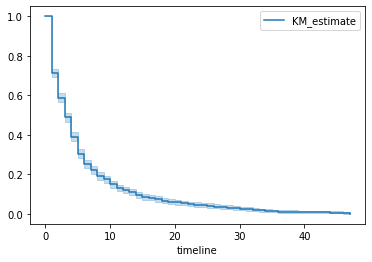

In [12]:
kmf = KaplanMeierFitter()
kmf.fit(regime_df["gov_duration"], regime_df["gov_observed_death"])
kmf.plot_survival_function()

In [13]:
def plot_multiple_groups(group_col):

    group_values = regime_df[group_col].unique()
    kmf = KaplanMeierFitter()

    for group in group_values:
        df_ = regime_df[regime_df[group_col] == group]

        kmf.fit(df_["gov_duration"], df_["gov_observed_death"], label=group)
        kmf.plot_survival_function()

#### Por tipo de regime

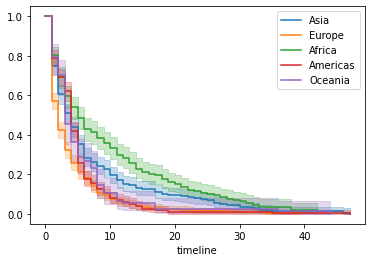

In [14]:
plot_multiple_groups("country_continent")

#### Se há democracia

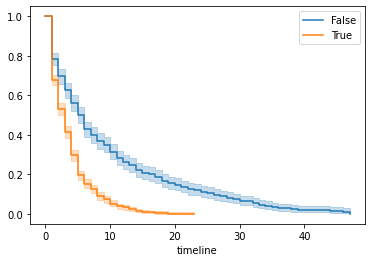

In [15]:
plot_multiple_groups("regime_is_democracy")

#### Por tipo de regime

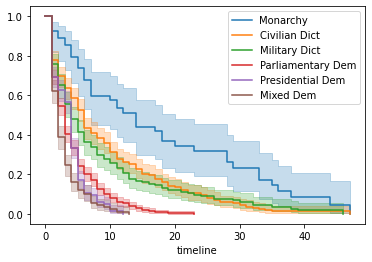

In [16]:
plot_multiple_groups("regime_type")

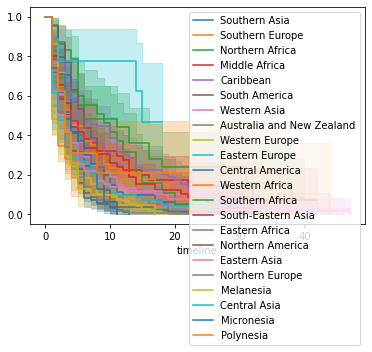

In [17]:
plot_multiple_groups("country_region")

## Modelagem inicial

In [18]:
from lifelines import CoxPHFitter

In [19]:
from sklearn.model_selection import train_test_split

#### Preparando os dados

In [20]:
model_cols_to_use = [
    "country_region", "regime_type", # features
    "gov_observed_death", "gov_duration" # duration col and observed event col
]

In [21]:
model_df = pd.get_dummies(regime_df[model_cols_to_use], drop_first=True)

Como vamos apenas rodar um modelo rápido (o desenvolvimento do modelo definitivo será em outro notebook, após considerar outras features), não gastaremos muito tempo aqui.

In [22]:
X_train, X_test = train_test_split(model_df)

#### Ajustando o modelo

In [25]:
cph = CoxPHFitter()
cph.fit(X_train, duration_col="gov_duration", event_col="gov_observed_death")

<lifelines.CoxPHFitter: fitted with 1355 total observations, 137 right-censored observations>

<AxesSubplot:xlabel='log(HR) (95% CI)'>

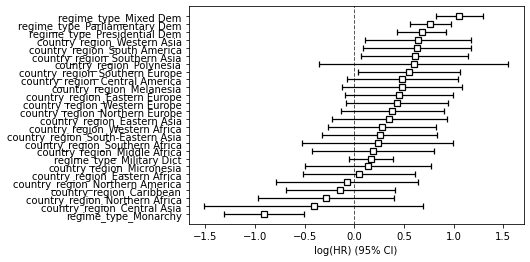

In [26]:
cph.plot()

In [27]:
cph.print_summary()

/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 1355 total observations, 137 right-censored observations>
             duration col = 'gov_duration'
                event col = 'gov_observed_death'
      baseline estimation = breslow
   number of observations = 1355
number of events observed = 1218
   partial log-likelihood = -7486.30
         time fit was run = 2022-05-21 00:19:45 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
country_region_Caribbean           -0.14       0.87       0.28            -0.69             0.41                 0.50                 1.51
country_region_Central America      0.48       1.62       0.28            -0.07             1.04                 0.93                 2.83
country_region_Central Asia        -0.41       0.66       0.56            -1.52             0.70                 0.22                 2.01
country_region_Eastern Africa       0.05       1.05       0.29            -0.51             0.62                 0.60                 1.85
country_region_Eastern Asia         0.35       1.42       0.30            -0.23             0.93                 0.80                 2.54
country_region_Eastern Europe       0.45       1.57       0.28            -0.10             1.00                 0.91                 2.71
country_region_Melanesia            0.48       1.62       0.31            -0.12             1.09                 0.89                 2.97
country_region_Micronesia           0.14       1.15       0.32            -0.50             0.78                 0.61                 2.18
country_region_Middle Africa        0.19       1.21       0.31            -0.42             0.81                 0.66                 2.24
country_region_Northern Africa     -0.28       0.75       0.35            -0.97             0.41                 0.38                 1.50
country_region_Northern America    -0.08       0.92       0.37            -0.79             0.64                 0.45                 1.89
country_region_Northern Europe      0.38       1.47       0.27            -0.14             0.90                 0.87                 2.47
country_region_Polynesia            0.60       1.82       0.49            -0.35             1.55                 0.70                 4.72
country_region_South America        0.63       1.88       0.28             0.09             1.18                 1.09                 3.24
country_region_South-Eastern Asia   0.26       1.29       0.30            -0.32             0.84                 0.72                 2.31
country_region_Southern Africa      0.24       1.27       0.39            -0.53             1.00                 0.59                 2.72
country_region_Southern Asia        0.61       1.84       0.28             0.07             1.15                 1.07                 3.16
country_region_Southern Europe      0.55       1.74       0.26             0.04             1.07                 1.04                 2.92
country_region_Western Africa       0.28       1.32       0.28            -0.27             0.83                 0.76                 2.29
country_region_Western Asia         0.64       1.90       0.27             0.11             1.17                 1.12                 3.24
country_region_Western Europe       0.43       1.54       0.26            -0.08             0.94                 0.92                 2.56
regime_type_Military Dict           0.17       1.18       0.11            -0.05             0.39                 0.95                 1.47
regime_type_Mixed Dem               1.06       2.88       0.12             0.83             1.29                 2.28                 3.64
regime_type_Monarchy               -0.91       0.40       0.21            -1.32            -0.51                 0.27                 0.60
regi

# Salvando arquivo

In [10]:
regime_df.to_csv("../data/preprocessed/regime_data.csv", index=False)